In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import (
    Dense, 
    Flatten, 
    Dropout,
    BatchNormalization,
    Activation
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [3]:
train_dataset='./train'
test_dataset='./test'


In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=5,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
def load_dataset(directory, subset, target_size, batch_size, class_mode):
    return train_datagen.flow_from_directory(
        directory=directory,
        target_size=target_size,
        class_mode=class_mode,
        subset=subset,
        batch_size=batch_size
    )

train_dataset = load_dataset(
    './train',
    'training',
    (48, 48),
    64,
    'categorical'
)
valid_dataset = load_dataset(
    './train',
    'validation',
    (48, 48),
    64,
    'categorical'
)

test_dataset = load_dataset(
    './test',
    None,
    (48, 48),
    64,
    'categorical'
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [7]:
from keras.models import Sequential
from keras.layers import Dropout, Flatten, BatchNormalization, Dense, Activation
from keras.applications import VGG16

# Load VGG16 model
base_model = VGG16(
    input_shape=(48, 48, 3),
    include_top=False,
    weights="imagenet"
)

# Set base model layers to non-trainable
for layer in base_model.layers[:-4]:
    layer.trainable = False

In [12]:
model = Sequential([
    base_model,
    Flatten(),
    BatchNormalization(),
    Dense(32, kernel_initializer='he_uniform'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(32, kernel_initializer='he_uniform'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(32, kernel_initializer='he_uniform'),
    BatchNormalization(),
    Activation('relu'),
    Dense(7, activation='softmax')
])

In [13]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
model.build(input_shape=(None, 48, 48, 3))

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 1, 1, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,735,879 (56.21 MB)

 Trainable params: 7,099,399 (27.08 MB)

 Non-trainable params: 7,636,480 (29.13 MB)

In [16]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    
]

In [17]:
lrd = ReduceLROnPlateau(
    monitor='val_loss',
    patience=20,
    verbose=1,
    factor=0.50,
    min_lr=1e-10
)

mcp = ModelCheckpoint('model.keras')

es = EarlyStopping(
    verbose=1,
    patience=20
)

In [18]:
model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=METRICS
)

history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=60,
    verbose=1,
    callbacks=[lrd, mcp, es]
)

Epoch 1/60


C:\Users\sahil\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


359/359 ━━━━━━━━━━━━━━━━━━━━ 327s 893ms/step - accuracy: 0.8518 - auc: 0.5949 - loss: 2.0102 - precision: 0.2672 - recall: 0.0196 - val_accuracy: 0.8577 - val_auc: 0.6844 - val_loss: 1.7783 - val_precision: 0.5102 - val_recall: 0.1005 - learning_rate: 0.0010
Epoch 2/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 344s 957ms/step - accuracy: 0.8593 - auc: 0.7159 - loss: 1.7024 - precision: 0.5735 - recall: 0.0582 - val_accuracy: 0.8635 - val_auc: 0.7441 - val_loss: 1.6399 - val_precision: 0.7049 - val_recall: 0.0770 - learning_rate: 0.0010
Epoch 3/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 370s 1s/step - accuracy: 0.8612 - auc: 0.7353 - loss: 1.6623 - precision: 0.5991 - recall: 0.0852 - val_accuracy: 0.8436 - val_auc: 0.7310 - val_loss: 1.7641 - val_precision: 0.4141 - val_recall: 0.2280 - learning_rate: 0.0010
Epoch 4/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 303s 841ms/step - accuracy: 0.8630 - auc: 0.7474 - loss: 1.6353 - precision: 0.6220 - recall: 0.1040 - val_accuracy: 0.8636 - val_auc: 0.7514 - val_loss: 1.6218 - v

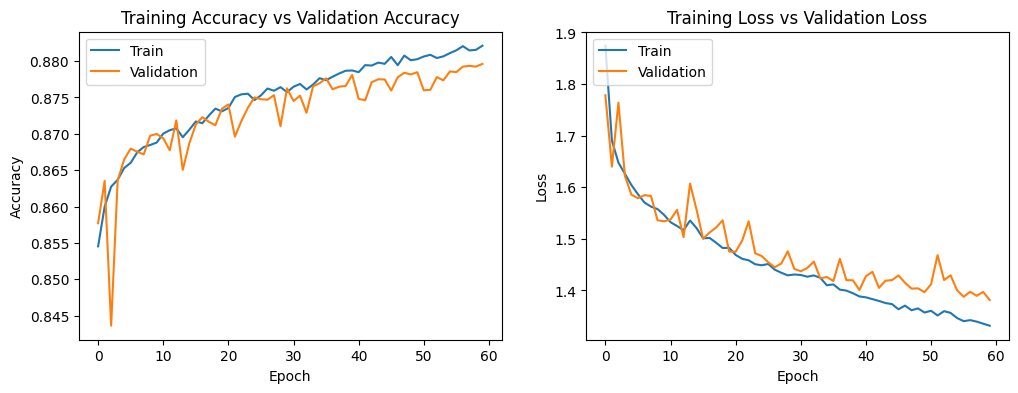

In [19]:
import matplotlib.pyplot as plt

fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [22]:
print("\nEvaluating the model on the test dataset...")
test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_dataset)

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")


Evaluating the model on the test dataset...


C:\Users\sahil\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


113/113 ━━━━━━━━━━━━━━━━━━━━ 60s 528ms/step - accuracy: 0.8816 - auc: 0.8439 - loss: 1.3361 - precision: 0.7463 - recall: 0.2586

Test Loss: 1.3492
Test Accuracy: 0.8815
Test Precision: 0.7456
Test Recall: 0.2593
Test AUC: 0.8407


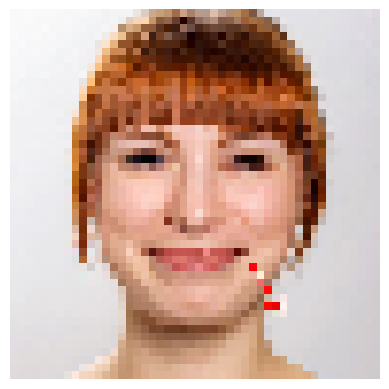

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
Predicted Emotion: Happy


In [42]:
import matplotlib.pyplot as plt
from keras.preprocessing import image

image_path = "../smile.jpg"
img = image.load_img(image_path, target_size=(48, 48)) 
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  
img_array = img_array / 255.0 

plt.imshow(img)
plt.axis('off')
plt.show()
prediction = model.predict(img_array)

predicted_class = np.argmax(prediction)

emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy',  'Neutral','Sad', 'Surprise']

predicted_emotion = emotion_labels[predicted_class]

print("Predicted Emotion:", predicted_emotion)


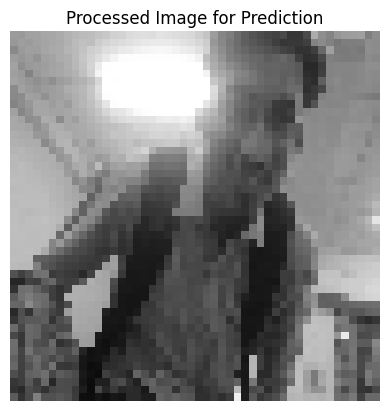

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Predicted Emotion: Sad


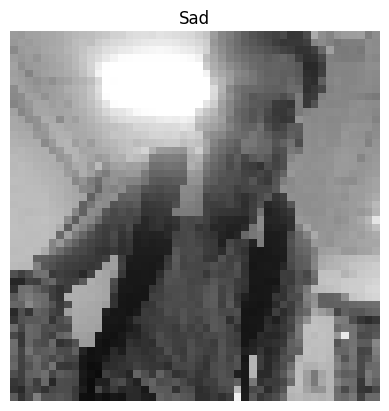

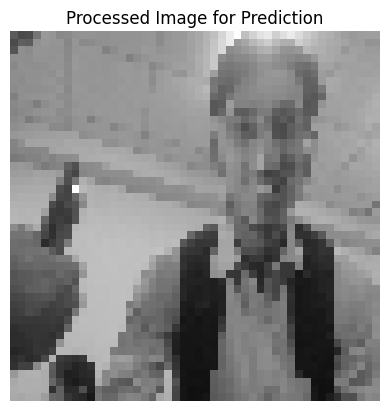

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Predicted Emotion: Fear


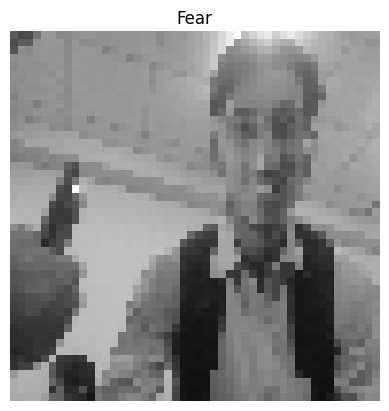

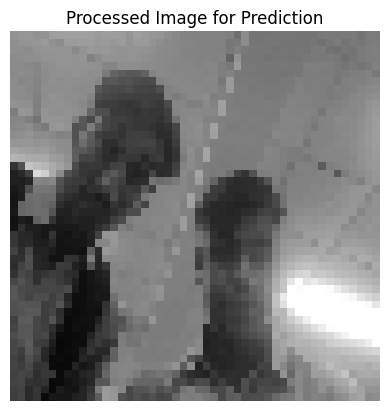

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Predicted Emotion: Sad


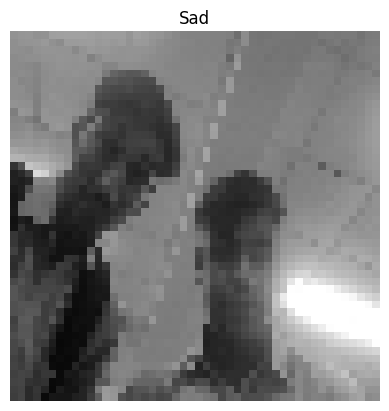

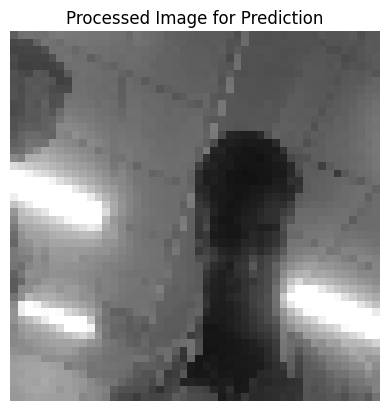

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Predicted Emotion: Sad


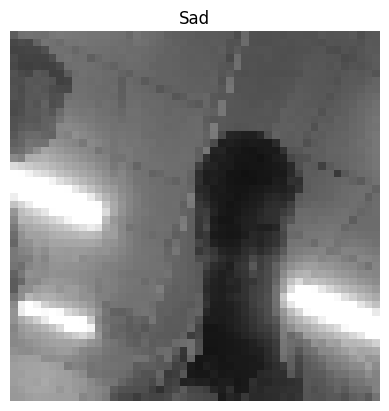

In [45]:
import cv2
import mediapipe as mp
import tkinter as tk
from PIL import Image, ImageTk
import customtkinter as ctk
import numpy as np
from keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt


ctk.set_appearance_mode("System")
ctk.set_default_color_theme("blue")

mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils

def get_gradient_color(landmark_index, total_landmarks):
    start_color = (255, 0, 127)
    end_color = (127, 0, 255)
    weight = landmark_index / (total_landmarks - 1)
    b = int(start_color[0] * (1 - weight) + end_color[0] * weight)
    g = int(start_color[1] * (1 - weight) + end_color[1] * weight)
    r = int(start_color[2] * (1 - weight) + end_color[2] * weight)
    return b, g, r

def get_connection_color(landmark_idx, landmark):
    num_landmarks = len(landmark.landmark)
    return get_gradient_color(landmark_idx, num_landmarks)

def capture_photo():
    global captured_photos
    ret, frame = cap.read()
    if ret:
        captured_photos.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        display_captured_photos()
        predict_emotion(frame)  

def display_captured_photos():
    if captured_photos:
        photo = captured_photos[-1]
        img = Image.fromarray(photo)
        img.thumbnail((400, 400))
        img = ImageTk.PhotoImage(image=img)
        captured_photo_label.config(image=img)
        captured_photo_label.image = img

def update_frame():
    global face_count  
    ret, frame = cap.read()
    if ret:
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(rgb_frame)
        if results.multi_face_landmarks is not None:
            face_count = len(results.multi_face_landmarks)
        else:
            face_count = 0
        if show_face_mesh and results.multi_face_landmarks:
            for face_landmarks in results.multi_face_landmarks:
                mp_drawing.draw_landmarks(
                    frame, face_landmarks, mp_face_mesh.FACEMESH_TESSELATION,
                    landmark_drawing_spec=mp_drawing.DrawingSpec(thickness=1, circle_radius=0),
                    connection_drawing_spec=mp_drawing.DrawingSpec(thickness=1, color=get_connection_color(0, face_landmarks))
                )
        cv2.putText(frame, f"Faces Detected: {face_count}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        img = ImageTk.PhotoImage(image=img)
        label.imgtk = img
        label.config(image=img)
        label.after(10, update_frame)
    else:
        root.quit()

def predict_emotion(frame):
    img = cv2.resize(frame, (48, 48))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    plt.imshow(img)
    plt.axis('off')
    plt.title("Processed Image for Prediction")
    plt.show()

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
    predicted_emotion = emotion_labels[predicted_class]

    print("Predicted Emotion:", predicted_emotion)
    plt.imshow(img)
    plt.axis('off')
    plt.title(predicted_emotion)
    plt.show()

face_count = 0
show_face_mesh = True
captured_photos = []
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=8, min_detection_confidence=0.5)
cap = cv2.VideoCapture(0)

root = ctk.CTk()
root.title("Face Mesh Detection")
root.geometry("600x1000")

label = tk.Label(root)
label.pack()

captured_photo_label = tk.Label(root, padx=10, pady=10)
captured_photo_label.pack()

capture_button = ctk.CTkButton(master=root, text="Capture", command=capture_photo)
capture_button.place(relx=0.5, rely=0.5, anchor=ctk.CENTER)



update_frame()

root.mainloop()

cap.release()
cv2.destroyAllWindows()
